In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import zarr
import os
import tqdm
# from tqdm.auto import trange
from tqdm.notebook import trange

from rad_utils import remove_all_ticks_and_labels

# swiss roll, posterior distribution
## sequential sampling using the posterior forward process
### single run of 100 cycles

embedding dimension is 2
model loaded!
the model has 34050 parameters


[(-1.5, 1.5), (-1.5, 1.5)]

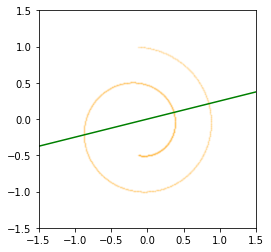

In [2]:
# rad ad + likelihood influence
from rad_utils import select_model, generate_2d_swiss_roll
from likelihood_utils import sequential_posterior_sampler
from rad_utils import select_model, plot_reverse_samples_10_steps
prior_sampler, num_steps, embedding_dims = select_model('unconditional-concat', 9)

v = np.array([[4, 1]]).T
M = v / np.linalg.norm(v)
Mm = M @ M.T
Mm = torch.from_numpy(Mm).float()

np.random.seed(0)
torch.random.manual_seed(1)
num_samples_in_gt_manifold = 1000
gt_manifold_t, gt_manifold, min, max = generate_2d_swiss_roll(num_samples_in_gt_manifold, rescaled=True)


fig, ax = plt.subplots(1, 1)
ax.set_aspect('equal')
ax.scatter(*gt_manifold.T, s=1, alpha=0.1, c='orange')
ls = np.linspace(-1, 1, 100)
ax.plot(ls * v[0], ls * v[1], c='green')
lim = 1.5
lims = [-lim, lim]
ax.set(xlim=lims, ylim=lims)

In [3]:
likelihood_sigma = 0.1
s = 0.1
num_cycles = 1000

In [ ]:
# num_samples_in_gt_manifold = 5e3

# initialize a random point on the ground truth manifold and start the sequential posterior sampling
manifold_initial_point = gt_manifold[np.random.randint(num_samples_in_gt_manifold)].reshape(1, -1)
seq_sampled_points, seq_reverse_points = sequential_posterior_sampler(prior_sampler, manifold_initial_point, M, likelihood_sigma, s, num_cycles, n_steps=100)

print(seq_sampled_points.shape)
print(seq_reverse_points.shape)


In [9]:
from likelihood_utils import save_or_load_to_zarr
# save_or_load_to_zarr('save', 'autocorrelation/seq_sampled_points', seq_sampled_points)
# save_or_load_to_zarr('save', 'autocorrelation/seq_reverse_points', seq_reverse_points)
seq_sampled_points = save_or_load_to_zarr('load', 'autocorrelation/seq_sampled_points')
seq_reverse_points = save_or_load_to_zarr('load', 'autocorrelation/seq_reverse_points')


loading!
loading!


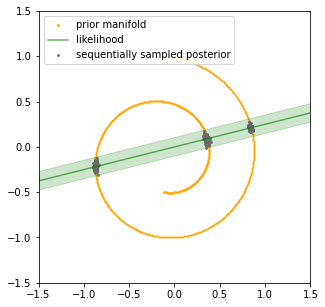

In [10]:
# plot the results of the sequential posterior sampling
fig, ax = plt.subplots(1, 1, figsize=(5,5))
ax.scatter(*gt_manifold[500].T, s=3, alpha=1, c='orange', label='prior manifold')
ax.scatter(*gt_manifold.T, s=0.5, alpha=1, c='orange')
ax.plot(ls * v[0], ls * v[1], c='green', alpha=0.6, label='likelihood')
below = ls * v[1] - likelihood_sigma / np.cos(np.arctan(v[1]/v[0]))
above = ls * v[1] + likelihood_sigma / np.cos(np.arctan(v[1]/v[0]))
ax.fill_between(ls * v[0], below, above, color='green', alpha=0.2)
ax.scatter(*seq_sampled_points.T, s=3, c='dimgrey', label='sequentially sampled posterior')
ax.set(xlim=lims, ylim=lims)
ax.set_aspect('equal')
ax.legend(loc="upper left")


Text(0.5, 0.98, 'sampling from the posterior distribution')

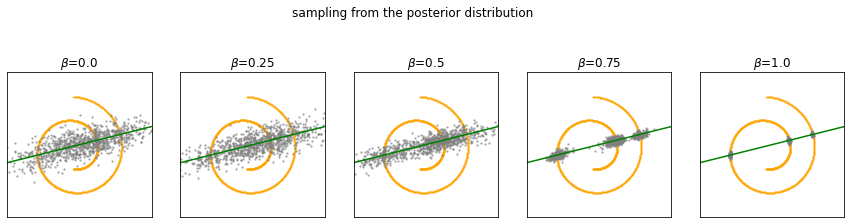

In [11]:
# plot the reverse process of the sequential posterior sampling at different temperatures
fig, ax = plt.subplots(1, 5, figsize=(15, 4), sharex=True, sharey=True)
idx = 0
for i in np.linspace(0, 100, 5):
    ax[idx].scatter(*gt_manifold.T, s=1, alpha=0.5, c='orange')
    ax[idx].scatter(*seq_reverse_points[:, int(i)].T, s=2, alpha=0.5, c='grey', label='$p(z_t\,|\,M^T z_t)$')
    # ax[idx].scatter(*z_gt.T, s=10, c='red', label='$z$ where $x=M^Tz+\epsilon$')
    ax[idx].plot(ls * v[0], ls * v[1], c='green')
    ax[idx].set(title=f'$\\beta$={int(i)/100}')
    ax[idx].set_aspect('equal')
    ax[idx].set(xlim=lims, ylim=lims)
    remove_all_ticks_and_labels(ax[idx])
    idx += 1
fig.suptitle('sampling from the posterior distribution')

## autocorrelation

### single run on samples of the posterior distribution

In [12]:
# we need to map the noisy points to the closest point on the clean manifold
from rad_utils import project_onto_clean_2d_roll_manifold
num_samples_in_gt_manifold = 5e3
gt_manifold_t, gt_manifold, min, max = generate_2d_swiss_roll(num_samples_in_gt_manifold, rescaled=True)

# project points onto the ground truth manifold
seq_sampled_projected_pts = []
for j in range(seq_sampled_points.shape[0]):
    _, manifold_pts_t = project_onto_clean_2d_roll_manifold(seq_sampled_points[j], gt_manifold, min, max, gt_manifold_t)
    seq_sampled_projected_pts.append(manifold_pts_t)

seq_sampled_projected_pts = np.stack(seq_sampled_projected_pts)
seq_sampled_projected_pts = seq_sampled_projected_pts.reshape(-1,)
print(seq_sampled_projected_pts.shape)


(1000,)


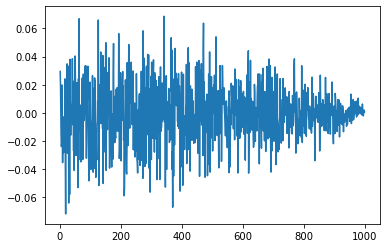

In [13]:
# plot the autocorrelation of the sequential posterior samples
from rad_utils import calculate_autocorrelation

ac = calculate_autocorrelation(seq_sampled_projected_pts)

fig, ax = plt.subplots(1, 1)
ax.plot(range(1, 1000), ac[1:])

### averaged autocorrelation over many runs

In [14]:
# averaged autocorrelation plot
from rad_utils import project_multiple_datasets_onto_ground_truth_roll_manifold

num_samples_in_gt_manifold = 2e3
gt_manifold_t, gt_manifold, min, max = clean_manifold_params = generate_2d_swiss_roll(num_samples_in_gt_manifold, rescaled=True)

num_runs = 2000
num_cycles = 50

In [134]:
runs = []
for i in trange(num_runs, position=0):
    # select a random point on the ground truth manifold
    manifold_initial_point = gt_manifold[np.random.randint(num_samples_in_gt_manifold)].reshape(1, -1)
    
    # run the sequential posterior sampler to generate (num_cycles) number of samples
    seq_sampled_points, _ = sequential_posterior_sampler(prior_sampler, manifold_initial_point, M, likelihood_sigma, s, num_cycles, n_steps=100, status_bar=False)

    # project points onto the ground truth manifold
    projected_points = project_multiple_datasets_onto_ground_truth_roll_manifold(seq_sampled_points, clean_manifold_params)
    
    # calculate the autocorrelation of the projected points
    ac = calculate_autocorrelation(projected_points)
    runs.append(ac)
ac_seq_swiss_roll_posterior = np.stack(runs)
print(ac_seq_swiss_roll_posterior.shape)

  0%|          | 0/2000 [00:00<?, ?it/s]

(2000, 50)


In [47]:
# save_or_load_to_zarr('save', name='autocorrelation/ac_seq_swiss_roll_posterior_runs=2000_cycles=50', data=ac_seq_swiss_roll_posterior)
ac_seq_swiss_roll_posterior = save_or_load_to_zarr('load', name='autocorrelation/ac_seq_swiss_roll_posterior_runs=2000_cycles=50')

loading!


(2000, 50)


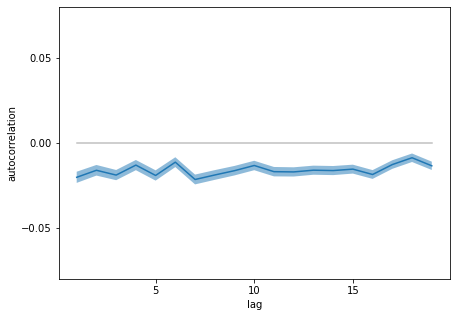

In [48]:
print(ac_seq_swiss_roll_posterior.shape)

# Plot average autocorrelation
num_lags_to_plot = 20
x_linspace = range(1, num_lags_to_plot)

fig, ax = plt.subplots(1, 1, figsize=(7, 5))
mean_seq = ac_seq_swiss_roll_posterior.mean(axis=0)
ax.plot(x_linspace, mean_seq[1:num_lags_to_plot])
error_seq = ac_seq_swiss_roll_posterior.std(axis=0) / np.sqrt(num_runs)
ax.fill_between(x_linspace, (mean_seq-error_seq)[1:num_lags_to_plot], (mean_seq+error_seq)[1:num_lags_to_plot], alpha=0.5)
ax.set(xlabel='lag', ylabel='autocorrelation')
# ax.set(title='sequential sampling of posterior distribution')
ax.set(ylim=[-.08, .08])
ax.plot(x_linspace, np.zeros_like(x_linspace), c='grey', alpha=0.5)
ax.set_yticks([-0.05, 0, 0.05])
ax.set_xticks(range(5, num_lags_to_plot+1, 5)[:-1])

save=True
if save==True:
    savedir = 'plots/neurips'
    figname = f'ac-sequential-sampling.pdf'
    plt.savefig(os.path.join(savedir, figname), transparent=True, bbox_inches='tight', dpi=400)

### autocorrelation comparison against iid sampling
compare the sequentially sampled posterior against the iid sampled posterior

does the iid sampled posterior also have negative autocorrelation? because that would indicate that it's not necessarily the sequential sampling that causes the negative autocorrelation; it's instead something to do with the manifold (that's common to both). 

In [49]:
# iid samples
num_runs = 2000
num_cycles = 50
sample_size = int(num_runs * num_cycles)  # should be 100 x 100
print('sample_size is', sample_size)

likelihood_sigma = 0.1
s = 0.1

prior_sampler, num_steps, embedding_dims = select_model('unconditional-concat', 9)
v = np.array([[4, 1]]).T
M = v / np.linalg.norm(v)

num_steps = 100

sample_size is 100000
embedding dimension is 2
model loaded!
the model has 34050 parameters


In [ ]:

from likelihood_utils import posterior_sample_loop_occlusion
from generate_data import p_sample_loop_new
iid_samples_posterior = posterior_sample_loop_occlusion(prior_sampler, M, likelihood_sigma, s, (sample_size, embedding_dims), num_steps, status_bar=True)
# iid_sampled_points = p_sample_loop_new(prior_sampler, (sample_size, embedding_dims), num_steps)

iid_samples_posterior = iid_samples_posterior.detach().numpy()

In [50]:
# save_or_load_to_zarr('save', name='autocorrelation/iid_samples_swiss_roll_posterior_num=1e4', data=iid_samples_swiss_roll_posterior)
# save_or_load_to_zarr('save', name='autocorrelation/iid_samples_swiss_roll_posterior_num=1e5', data=iid_samples_swiss_roll_posterior)
iid_samples_swiss_roll_posterior = save_or_load_to_zarr('load', name='autocorrelation/iid_samples_swiss_roll_posterior_num=1e5')
iid_samples_swiss_roll_posterior = iid_samples_swiss_roll_posterior[-1].reshape(num_runs, num_cycles, -1)
print(iid_samples_swiss_roll_posterior.shape)

loading!
(2000, 50, 2)


<AxesSubplot:>

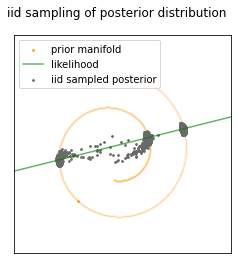

In [51]:
fig, ax = plt.subplots(1, 1)
ax.scatter(*gt_manifold[1200].T, s=3, alpha=1, c='orange', label='prior manifold')
ax.scatter(*gt_manifold.T, s=1, alpha=0.05, c='orange')
ax.plot(ls * v[0], ls * v[1], c='green', alpha=0.6, label='likelihood')
ax.scatter(*iid_samples_swiss_roll_posterior.T, s=3, c='dimgrey', label='iid sampled posterior')
ax.set(xlim=lims, ylim=lims)
ax.set_aspect('equal')
ax.legend(loc="upper left")
fig.suptitle('iid sampling of posterior distribution')
remove_all_ticks_and_labels(ax)

In [57]:
# project onto ground truth manifold and calculate autocorrelation
ac_iid_swiss_roll_posterior = []

for i in trange(num_runs):    
    # project points onto the ground truth manifold
    projected_points = project_multiple_datasets_onto_ground_truth_roll_manifold(iid_samples_swiss_roll_posterior[i], clean_manifold_params)
    
    ac = calculate_autocorrelation(projected_points)
    ac_iid_swiss_roll_posterior.append(ac)
ac_iid_swiss_roll_posterior = np.stack(ac_iid_swiss_roll_posterior)
print(ac_iid_swiss_roll_posterior.shape)

  0%|          | 0/2000 [00:00<?, ?it/s]

(2000, 50)


In [58]:
save_or_load_to_zarr('save', name='autocorrelation/ac_iid_swiss_roll_posterior_runs=2000_cycles=50', data=ac_iid_swiss_roll_posterior)

saved!


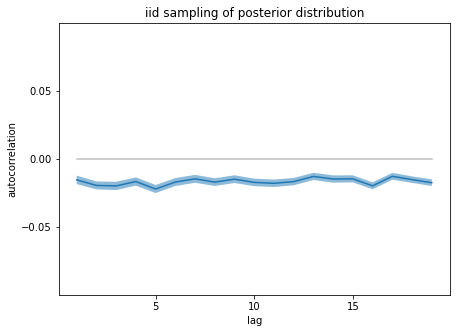

In [59]:
# plot autocorrelation of iid samples
# x_linspace = range(ac_iid_swiss_roll_posterior.shape[0])
num_lags_to_plot = 20
x_linspace = range(1, num_lags_to_plot)

fig, ax = plt.subplots(1, 1, figsize=(7, 5))
mean_iid = ac_iid_swiss_roll_posterior.mean(axis=0)[1:num_lags_to_plot]
ax.plot(x_linspace, mean_iid)
error_iid = ac_iid_swiss_roll_posterior.std(axis=0)[1:num_lags_to_plot] / np.sqrt(num_runs)
ax.fill_between(x_linspace, mean_iid-error_iid, mean_iid+error_iid, alpha=0.5)
ax.set(xlabel='lag', ylabel='autocorrelation')
ax.set(title='iid sampling of posterior distribution')
ax.set(ylim=[-.1, .1])
ax.plot(x_linspace, np.zeros_like(x_linspace), c='grey', alpha=0.5)
ax.set_yticks([-0.05, 0, 0.05])
ax.set_xticks(range(5, num_lags_to_plot+1, 5)[:-1])

The fact that this is the also true for the iid sampling of the posterior distribution suggests that this has something to do with the manifold itself. 

Some possibilities:
- Is this because I'm looking at the posterior distribution, as opposed to the prior distribution?
- Could it be that the manifold itself is leading to negative autocorrelation? Try with a line manifold and see if that still produces the wrong things
- or maybe it's because the ground truth manifold data points aren't uniformly distributed on the 1d latent line. I could try to fix that and see if it changes anything? I don't think this is right because this would only really affect the projection step (there are three steps: 1. generating samples, 2. projecting them onto the ground truth manifold, and 3. calculating the autocorrelation using the projected points). 


Let's try with the prior swiss roll samples, and then the line manifold. 

(2000, 50)


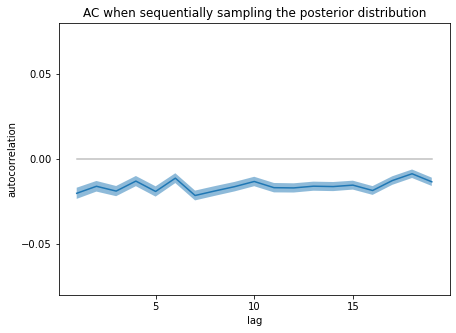

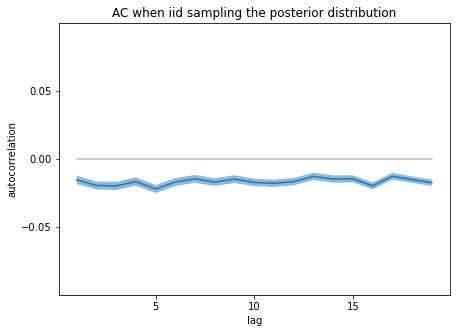

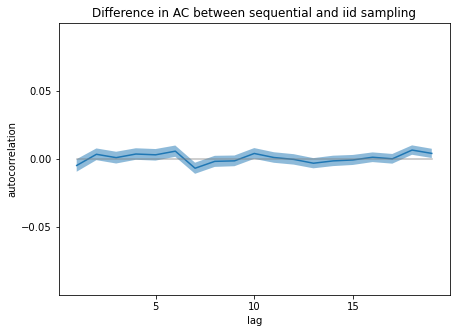

In [60]:
# difference in autocorrelation between iid and sequential sampling

print(ac_seq_swiss_roll_posterior.shape)

# Plot average autocorrelation
# x_linspace = range(1, ac_seq_swiss_roll_posterior.shape[0])
num_lags_to_plot = 20
x_linspace = range(1, num_lags_to_plot)

fig, ax = plt.subplots(1, 1, figsize=(7, 5))
mean_seq = ac_seq_swiss_roll_posterior.mean(axis=0)
ax.plot(x_linspace, mean_seq[1:num_lags_to_plot])
error_seq = ac_seq_swiss_roll_posterior.std(axis=0) / np.sqrt(num_runs)
ax.fill_between(x_linspace, (mean_seq-error_seq)[1:num_lags_to_plot], (mean_seq+error_seq)[1:num_lags_to_plot], alpha=0.5)
ax.set(xlabel='lag', ylabel='autocorrelation')
ax.set(title='AC when sequentially sampling the posterior distribution')
ax.set(ylim=[-.08, .08])
ax.plot(x_linspace, np.zeros_like(x_linspace), c='grey', alpha=0.5)
ax.set_yticks([-0.05, 0, 0.05])
ax.set_xticks(range(5, num_lags_to_plot+1, 5)[:-1])

save=False
if save==True:
    savedir = 'plots/neurips'
    figname = f'ac-sequential-sampling.pdf'
    plt.savefig(os.path.join(savedir, figname), transparent=True, bbox_inches='tight', dpi=400)



# plot autocorrelation of iid samples
# x_linspace = range(ac_iid_posterior.shape[0])
num_lags_to_plot = 20
x_linspace = range(1, num_lags_to_plot)

fig, ax = plt.subplots(1, 1, figsize=(7, 5))
mean_iid = ac_iid_swiss_roll_posterior.mean(axis=0)[1:num_lags_to_plot]
ax.plot(x_linspace, mean_iid)
error_iid = ac_iid_swiss_roll_posterior.std(axis=0)[1:num_lags_to_plot] / np.sqrt(num_runs)
ax.fill_between(x_linspace, mean_iid-error_iid, mean_iid+error_iid, alpha=0.5)
ax.set(xlabel='lag', ylabel='autocorrelation')
ax.set(title='AC when iid sampling the posterior distribution')
ax.set(ylim=[-.1, .1])
ax.plot(x_linspace, np.zeros_like(x_linspace), c='grey', alpha=0.5)
ax.set_yticks([-0.05, 0, 0.05])
ax.set_xticks(range(5, num_lags_to_plot+1, 5)[:-1])


# calculate the difference in AC
diff_ac = ac_seq_swiss_roll_posterior - ac_iid_swiss_roll_posterior
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
mean_diff = diff_ac.mean(axis=0)[1:num_lags_to_plot]
ax.plot(x_linspace, mean_diff)

error_diff = diff_ac.std(axis=0)[1:num_lags_to_plot] / np.sqrt(num_runs)
ax.fill_between(x_linspace, mean_diff-error_diff, mean_diff+error_diff, alpha=0.5)
ax.set(xlabel='lag', ylabel='autocorrelation')
ax.set(title='Difference in AC between sequential and iid sampling')
ax.set(ylim=[-.1, .1])
ax.plot(x_linspace, np.zeros_like(x_linspace), c='grey', alpha=0.5)
ax.set_yticks([-0.05, 0, 0.05])
ax.set_xticks(range(5, num_lags_to_plot+1, 5)[:-1])


# Swiss roll, Prior distribution

## iid sampling

embedding dimension is 2
model loaded!
the model has 34050 parameters


[(-1.5, 1.5), (-1.5, 1.5)]

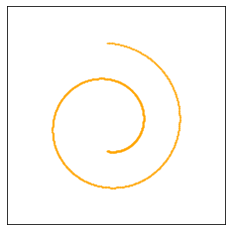

In [61]:
# rad ad + likelihood influence
from rad_utils import select_model, generate_2d_swiss_roll
from likelihood_utils import sequential_posterior_sampler
from rad_utils import select_model, plot_reverse_samples_10_steps
prior_sampler, num_steps, embedding_dims = select_model('unconditional-concat', 9)

np.random.seed(0)
torch.random.manual_seed(1)
num_samples_in_gt_manifold = 1000
gt_manifold_t, gt_manifold, min, max = generate_2d_swiss_roll(num_samples_in_gt_manifold, rescaled=True)

fig, ax = plt.subplots(1, 1)
ax.set_aspect('equal')
ax.scatter(*gt_manifold.T, s=1, alpha=0.5, c='orange')
remove_all_ticks_and_labels(ax)

lim = 1.5
lims = [-lim, lim]
ax.set(xlim=lims, ylim=lims)

In [87]:
# iid samples
num_runs = 4000
num_cycles = 50

sample_size = int(num_runs * num_cycles)  # should be 100 x 100

from generate_data import p_sample_loop_new

iid_samples_swiss_roll_prior = p_sample_loop_new(prior_sampler, (sample_size, 2), n_steps=100)
iid_samples_swiss_roll_prior = iid_samples_swiss_roll_prior[-1].reshape(num_runs, num_cycles, -1)
iid_samples_swiss_roll_prior = iid_samples_swiss_roll_prior.detach().numpy()

In [88]:
save_or_load_to_zarr('save', name='autocorrelation/iid_samples_swiss_roll_prior_num=2e5', data=iid_samples_swiss_roll_prior)

saved!


In [89]:
# project onto ground truth manifold and calculate autocorrelation
ac_iid_swiss_roll_prior = []
for i in trange(num_runs):
    projected_points = project_multiple_datasets_onto_ground_truth_roll_manifold(iid_samples_swiss_roll_prior[i], clean_manifold_params)
    
    ac = calculate_autocorrelation(projected_points)
    ac_iid_swiss_roll_prior.append(ac)
ac_iid_swiss_roll_prior = np.stack(ac_iid_swiss_roll_prior)
print(ac_iid_swiss_roll_prior.shape)

  0%|          | 0/4000 [00:00<?, ?it/s]

(4000, 50)


In [90]:
save_or_load_to_zarr('save', name='autocorrelation/ac_iid_swiss_roll_prior_runs=4000_cycles=50', data=ac_iid_swiss_roll_prior)

saved!


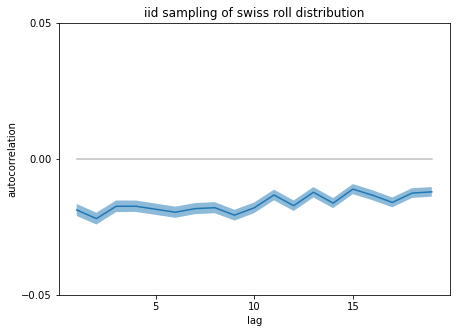

In [91]:
# plot autocorrelation of iid samples
num_lags_to_plot = 20
x_linspace = range(1, num_lags_to_plot)

fig, ax = plt.subplots(1, 1, figsize=(7, 5))
mean_iid = ac_iid_swiss_roll_prior.mean(axis=0)[1:num_lags_to_plot]
ax.plot(x_linspace, mean_iid)
error_iid = ac_iid_swiss_roll_prior.std(axis=0)[1:num_lags_to_plot] / np.sqrt(num_runs)
ax.fill_between(x_linspace, mean_iid-error_iid, mean_iid+error_iid, alpha=0.5)
ax.set(xlabel='lag', ylabel='autocorrelation')
ax.set(title='iid sampling of swiss roll distribution')
ax.set(ylim=[-.05, .05])
ax.plot(x_linspace, np.zeros_like(x_linspace), c='grey', alpha=0.5)
ax.set_yticks([-0.05, 0, 0.05])
ax.set_xticks(range(5, num_lags_to_plot+1, 5)[:-1])

## sequential prior sampling

In [94]:
# averaged autocorrelation plot
from rad_utils import project_multiple_datasets_onto_ground_truth_roll_manifold
from rad_utils import sequential_prior_sampler

num_samples_in_gt_manifold = 1e3
gt_manifold_t, gt_manifold, min, max = clean_manifold_params = generate_2d_swiss_roll(num_samples_in_gt_manifold, rescaled=True)

num_runs = 4000
num_cycles = 50
runs = []
for i in trange(num_runs):
    # select a random point on the ground truth manifold
    manifold_initial_point = gt_manifold[np.random.randint(num_samples_in_gt_manifold)].reshape(1, -1)
    
    # run the sequential posterior sampler to generate (num_cycles) number of samples
    seq_sampled_points, _, _ = sequential_prior_sampler(prior_sampler, manifold_initial_point, num_cycles, disable_tqdm=True)

    # project points onto the ground truth manifold
    projected_points = project_multiple_datasets_onto_ground_truth_roll_manifold(seq_sampled_points, clean_manifold_params)
    
    # calculate the autocorrelation of the projected points
    ac = calculate_autocorrelation(projected_points)
    runs.append(ac)
ac_seq_swiss_roll_prior = np.stack(runs)
print(ac_seq_swiss_roll_prior.shape)

  0%|          | 0/4000 [00:00<?, ?it/s]

(4000, 50)


In [95]:
# save the autocorrelation runs
zarr.save('saved_arrays/autocorrelation/ac_seq_swiss_roll_prior_runs=4000_cycles=50.zarr', ac_seq_swiss_roll_prior)

(4000, 50)


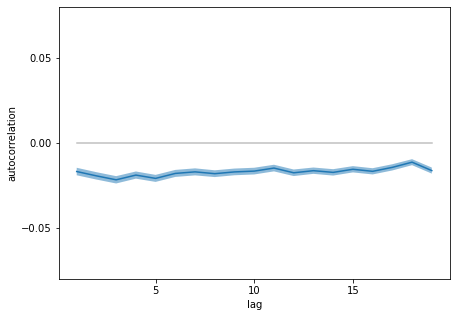

In [96]:
# plot 
print(ac_seq_swiss_roll_prior.shape)

# Plot average autocorrelation
# x_linspace = range(1, ac_seq_swiss_roll_prior.shape[0])
num_lags_to_plot = 20
x_linspace = range(1, num_lags_to_plot)

fig, ax = plt.subplots(1, 1, figsize=(7, 5))
mean_seq = ac_seq_swiss_roll_prior.mean(axis=0)
ax.plot(x_linspace, mean_seq[1:num_lags_to_plot])
error_seq = ac_seq_swiss_roll_prior.std(axis=0) / np.sqrt(num_runs)
ax.fill_between(x_linspace, (mean_seq-error_seq)[1:num_lags_to_plot], (mean_seq+error_seq)[1:num_lags_to_plot], alpha=0.5)
ax.set(xlabel='lag', ylabel='autocorrelation')
# ax.set(title='sequential sampling of posterior distribution')
ax.set(ylim=[-.08, .08])
ax.plot(x_linspace, np.zeros_like(x_linspace), c='grey', alpha=0.5)
ax.set_yticks([-0.05, 0, 0.05])
ax.set_xticks(range(5, num_lags_to_plot+1, 5)[:-1])

save=False
if save==True:
    savedir = 'plots/neurips'
    figname = f'ac-sequential-sampling.pdf'
    plt.savefig(os.path.join(savedir, figname), transparent=True, bbox_inches='tight', dpi=400)

loading!
loading!


[Text(0.5, 1.0, 'Difference in AC between sequential and iid sampling')]

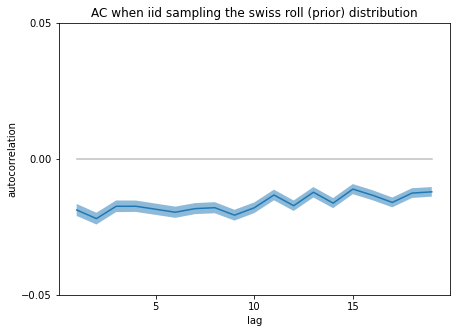

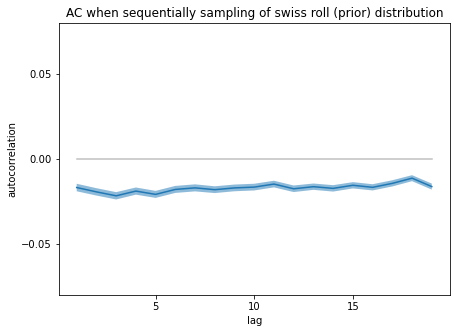

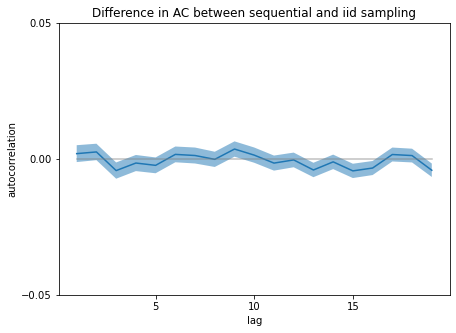

In [100]:
# comparison
num_lags_to_plot = 20
x_linspace = range(1, num_lags_to_plot)

# data
ac_iid_swiss_roll_prior = save_or_load_to_zarr('load', 'autocorrelation/ac_iid_swiss_roll_prior_runs=4000_cycles=50')
ac_seq_swiss_roll_prior = save_or_load_to_zarr('load', 'autocorrelation/ac_seq_swiss_roll_prior_runs=4000_cycles=50')

fig, ax = plt.subplots(1, 1, figsize=(7, 5))
mean_iid = ac_iid_swiss_roll_prior.mean(axis=0)[1:num_lags_to_plot]
ax.plot(x_linspace, mean_iid)
error_iid = ac_iid_swiss_roll_prior.std(axis=0)[1:num_lags_to_plot] / np.sqrt(num_runs)
ax.fill_between(x_linspace, mean_iid-error_iid, mean_iid+error_iid, alpha=0.5)
ax.set(xlabel='lag', ylabel='autocorrelation')
ax.set(title='AC when iid sampling the swiss roll (prior) distribution')
ax.set(ylim=[-.05, .05])
ax.plot(x_linspace, np.zeros_like(x_linspace), c='grey', alpha=0.5)
ax.set_yticks([-0.05, 0, 0.05])
ax.set_xticks(range(5, num_lags_to_plot+1, 5)[:-1])

fig, ax = plt.subplots(1, 1, figsize=(7, 5))
mean_seq = ac_seq_swiss_roll_prior.mean(axis=0)[1:num_lags_to_plot]
ax.plot(x_linspace, mean_seq)
error_seq = ac_seq_swiss_roll_prior.std(axis=0)[1:num_lags_to_plot] / np.sqrt(num_runs)
ax.fill_between(x_linspace, (mean_seq-error_seq), (mean_seq+error_seq), alpha=0.5)
ax.set(xlabel='lag', ylabel='autocorrelation')
ax.set(title='AC when sequentially sampling of swiss roll (prior) distribution')
ax.set(ylim=[-.08, .08])
ax.plot(x_linspace, np.zeros_like(x_linspace), c='grey', alpha=0.5)
ax.set_yticks([-0.05, 0, 0.05])
ax.set_xticks(range(5, num_lags_to_plot+1, 5)[:-1])

ac_swiss_roll_prior_diff = ac_seq_swiss_roll_prior - ac_iid_swiss_roll_prior
mean_diff = ac_swiss_roll_prior_diff.mean(axis=0)[1:num_lags_to_plot]
std_diff = ac_swiss_roll_prior_diff.std(axis=0)[1:num_lags_to_plot] / np.sqrt(num_runs)

fig, ax = plt.subplots(1, 1, figsize=(7, 5))
ax.plot(x_linspace, mean_diff)
ax.fill_between(x_linspace, mean_diff-std_diff, mean_diff+std_diff, alpha=0.5)
ax.plot(x_linspace, np.zeros_like(x_linspace), c='grey', alpha=0.5)
ax.set(xlabel='lag', ylabel='autocorrelation')
ax.set_xticks(range(5, num_lags_to_plot+1, 5)[:-1])
ax.set_yticks([-0.05, 0, 0.05])
ax.set(title='Difference in AC between sequential and iid sampling')

----
# Line manifold

## iid samples

embedding dimension is 2
model loaded!
the model has 133634 parameters
size of the training set is 300000


[Text(0.5, 1.0, 'ground truth data distribution')]

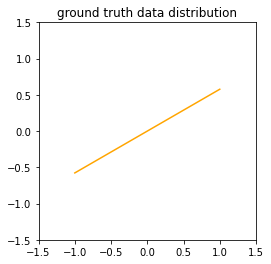

In [30]:
prior_sampler_line, num_steps_line, embedding_dims_line = select_model('unconditional-concat', 12)

num_samples = 3e5

# data
from generate_data import load_unimodal_data
gt_manifold_line = load_unimodal_data(num_samples, manifold_type='line', noise=0, plot=False)
t = np.linspace(-1, 1, int(num_samples))
angle = np.pi/6
x = t * np.cos(angle)
y = t * np.sin(angle)

fig, ax = plt.subplots(1, 1)
ax.plot(*gt_manifold_line.T, c='orange', alpha=1, label='data')
ax.set(xlim=lims, ylim=lims)
ax.set_aspect('equal')
ax.set(title='ground truth data distribution')

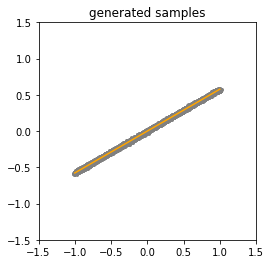

In [32]:
# iid samples
num_runs = 2000
num_cycles = 50

sample_size = int(num_runs * num_cycles)  # should be 100 x 100

from generate_data import p_sample_loop_new

iid_sampled_points = p_sample_loop_new(prior_sampler_line, (sample_size, 2), n_steps=100)[-1]
fig, ax = plt.subplots(1, 1)
ax.plot(*gt_manifold_line.T, c='orange', alpha=1, label='data')
ax.scatter(*iid_sampled_points.T, c='grey', alpha=1, s=3, label='iid samples')
ax.set(xlim=lims, ylim=lims)
ax.set_aspect('equal')
ax.set(title='generated samples')

iid_sampled_points = iid_sampled_points.detach().numpy().reshape(num_runs, num_cycles, -1)

In [33]:
# project onto ground truth manifold and calculate autocorrelation
from rad_utils import project_onto_clean_line_manifold

runs_iid = []
for i in trange(num_runs):
    # project onto ground truth line manifold
    projected_points_xy, projected_points_t = project_onto_clean_line_manifold(iid_sampled_points[i], gt_manifold_line, t, angle)
    
    ac = calculate_autocorrelation(projected_points_t)
    runs_iid.append(ac)
runs_iid = np.stack(runs_iid)
print(runs_iid.shape)

  0%|          | 0/2000 [00:00<?, ?it/s]

(2000, 50)


[(-1.0, 1.0)]

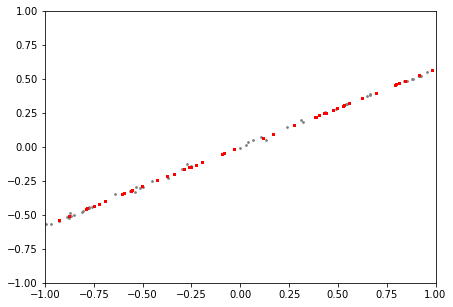

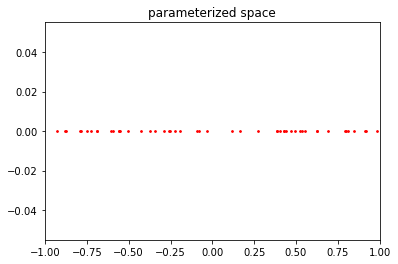

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
ax.scatter(*iid_sampled_points[0].T, c='grey', alpha=1, s=3, label='iid samples')
ax.scatter(*projected_points_xy.T, c='red', alpha=1, s=3, label='projected samples')
ax.set(xlim=[-1, 1], ylim=[-1, 1])

fig, ax = plt.subplots(1, 1)
ax.scatter(projected_points_t, np.zeros(len(projected_points_t)), c='red', alpha=1, s=3, label='projected samples')
ax.set(title='parameterized space')
ax.set(xlim=[-1, 1])

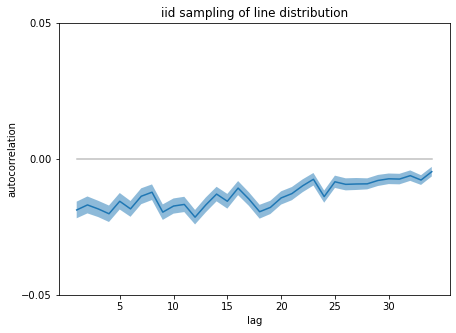

In [35]:
# plot autocorrelation of iid samples
num_lags_to_plot = 35
x_linspace = range(1, num_lags_to_plot)

fig, ax = plt.subplots(1, 1, figsize=(7, 5))
mean_iid = runs_iid.mean(axis=0)[1:num_lags_to_plot]
ax.plot(x_linspace, mean_iid)
error_iid = runs_iid.std(axis=0)[1:num_lags_to_plot] / np.sqrt(num_runs)
ax.fill_between(x_linspace, mean_iid-error_iid, mean_iid+error_iid, alpha=0.5)
ax.set(xlabel='lag', ylabel='autocorrelation')
ax.set(title='iid sampling of line distribution')
ax.set(ylim=[-.05, .05])
ax.plot(x_linspace, np.zeros_like(x_linspace), c='grey', alpha=0.5)
ax.set_yticks([-0.05, 0, 0.05])
ax.set_xticks(range(5, num_lags_to_plot+1, 5)[:-1])

----